In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from glob import glob
import seaborn as sns

from PIL import Image
np.random.seed(123)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

import shutil
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from numba import jit, cuda 

In [2]:
print(tensorflow.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print(tensorflow.reduce_sum(tensorflow.random.normal([1000, 1000])))

tf.Tensor(-1497.1289, shape=(), dtype=float32)


In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
root_path = 'Data'
train_path = 'Data/ISIC_2019_Training_Input'

In [4]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

In [5]:
# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

In [6]:
# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'NV')
os.mkdir(nv)
mel = os.path.join(train_dir, 'MEL')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'BKL')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'BCC')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'AK')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'VASC')
os.mkdir(vasc)
df = os.path.join(train_dir, 'DF')
os.mkdir(df)
df = os.path.join(train_dir, 'SCC')
os.mkdir(df)
df = os.path.join(train_dir, 'UNK')
os.mkdir(df)

In [7]:
# create new folders inside val_dir
nv = os.path.join(val_dir, 'NV')
os.mkdir(nv)
mel = os.path.join(val_dir, 'MEL')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'BKL')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'BCC')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'AK')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'VASC')
os.mkdir(vasc)
df = os.path.join(val_dir, 'DF')
os.mkdir(df)
df = os.path.join(val_dir, 'SCC')
os.mkdir(df)
df = os.path.join(val_dir, 'UNK')
os.mkdir(df)

In [7]:
metadata_path = 'ISIC_2019_Training_Metadata.csv'
df_meta = pd.read_csv(metadata_path)
df_meta.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [8]:
gt_path = 'ISIC_2019_Training_GroundTruth.csv'
df_gt = pd.read_csv(gt_path)
df_gt.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_cell_type = pd.DataFrame([x for x in np.where(df_gt == 1, df_gt.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))

In [11]:
df_cell_type.head()

,dx
0,NV
1,NV
2,MEL
3,NV
4,MEL


In [12]:
df = pd.concat([df_meta, df_cell_type], axis=1, join='inner')
df.head()

,image,age_approx,anatom_site_general,lesion_id,sex,dx
0,ISIC_0000000,55.0,anterior torso,NaN,female,NV
1,ISIC_0000001,30.0,anterior torso,NaN,female,NV
2,ISIC_0000002,60.0,upper extremity,NaN,female,MEL
3,ISIC_0000003,30.0,upper extremity,NaN,male,NV
4,ISIC_0000004,80.0,posterior torso,NaN,male,MEL


In [13]:
df.isnull().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dx                        0
dtype: int64

In [14]:
df['age_approx'].fillna((df['age_approx'].mean()), inplace=True)

In [15]:
df.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)

In [16]:
df.isnull().sum()

image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dx                     0
dtype: int64

In [18]:
df['image'].head()

1459    ISIC_0012653_downsampled
1460    ISIC_0012654_downsampled
1461    ISIC_0012655_downsampled
1462    ISIC_0012656_downsampled
1463    ISIC_0012657_downsampled
Name: image, dtype: object

In [19]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(root_path, '*', '*.jpg'))}

lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC': 'Squamous cell carcinoma',
    'UNK': 'None of the others'
}

# Creating New Columns for better readability

df['path'] = df['image'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.tail()

,image,age_approx,anatom_site_general,lesion_id,sex,dx,path,cell_type,cell_type_idx
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,Data\ISIC_2019_Training_Input\ISIC_0073247.jpg,Basal cell carcinoma,1
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,Data\ISIC_2019_Training_Input\ISIC_0073248.jpg,Benign keratosis-like lesions,2
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,Data\ISIC_2019_Training_Input\ISIC_0073249.jpg,Melanoma,5
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,Data\ISIC_2019_Training_Input\ISIC_0073251.jpg,Melanocytic nevi,4
25330,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,Data\ISIC_2019_Training_Input\ISIC_0073254.jpg,Benign keratosis-like lesions,2


<Axes: >

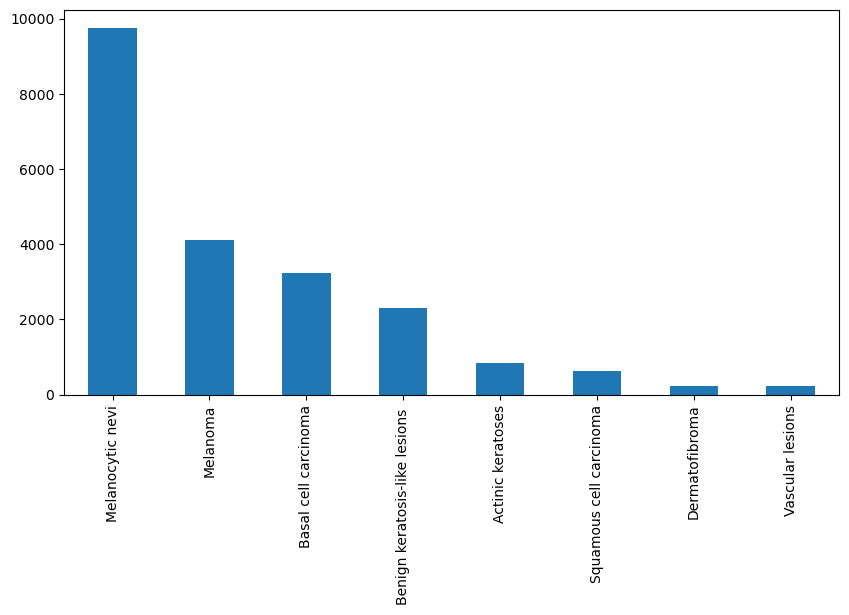

In [20]:
# Distribution of 9 classes
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: >

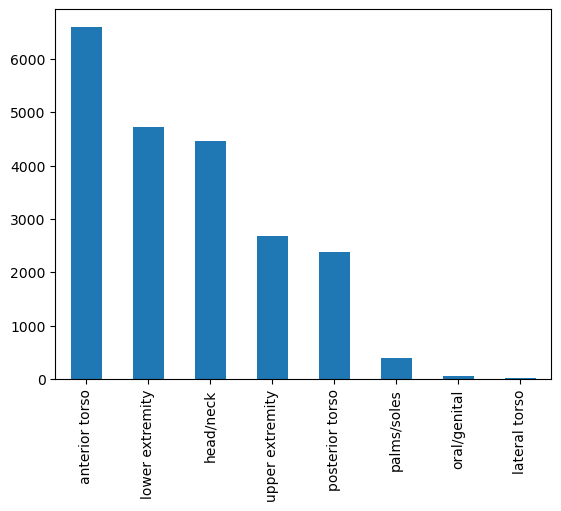

In [21]:
# Plotting the distribution of localization field
df['anatom_site_general'].value_counts().plot(kind='bar')

<Axes: >

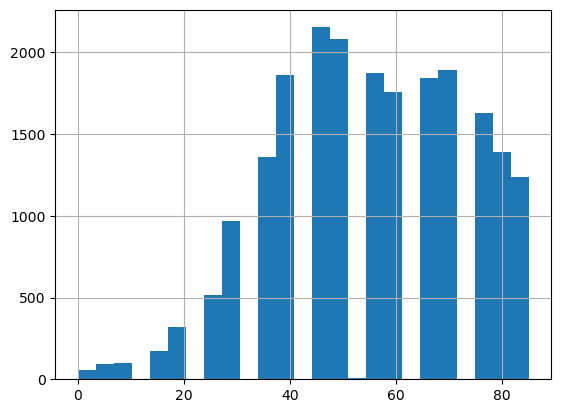

In [22]:
# Check the distribution of Age
df['age_approx'].hist(bins=25)

<Axes: >

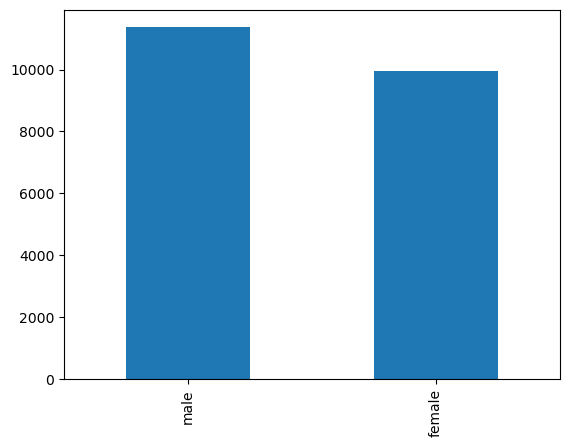

In [23]:
# Distribution of males and females
df['sex'].value_counts().plot(kind='bar')

In [24]:
# this will tell us how many images are associated with each lesion_id
df_ = df.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df_ = df_[df_['image'] == 1]

df_.reset_index(inplace=True)

df_.head()

,lesion_id,image,age_approx,anatom_site_general,sex,dx,path,cell_type,cell_type_idx
0,BCN_0000013,1,1,1,1,1,1,1,1
1,BCN_0000020,1,1,1,1,1,1,1,1
2,BCN_0000039,1,1,1,1,1,1,1,1
3,BCN_0000053,1,1,1,1,1,1,1,1
4,BCN_0000059,1,1,1,1,1,1,1,1


In [25]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df_['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df['duplicates'] = df['lesion_id']
# apply the function to this new column
df['duplicates'] = df['duplicates'].apply(identify_duplicates)

df.tail()

,image,age_approx,anatom_site_general,lesion_id,sex,dx,path,cell_type,cell_type_idx,duplicates
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,Data\ISIC_2019_Training_Input\ISIC_0073247.jpg,Basal cell carcinoma,1,has_duplicates
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,Data\ISIC_2019_Training_Input\ISIC_0073248.jpg,Benign keratosis-like lesions,2,has_duplicates
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,Data\ISIC_2019_Training_Input\ISIC_0073249.jpg,Melanoma,5,has_duplicates
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,Data\ISIC_2019_Training_Input\ISIC_0073251.jpg,Melanocytic nevi,4,has_duplicates
25330,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,Data\ISIC_2019_Training_Input\ISIC_0073254.jpg,Benign keratosis-like lesions,2,has_duplicates


In [26]:
df['duplicates'].value_counts()

has_duplicates    15959
no_duplicates      5357
Name: duplicates, dtype: int64

In [27]:
# now we filter out images that don't have duplicates
df_ = df[df['duplicates'] == 'no_duplicates']

df_.shape

(5357, 10)

In [28]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df_['dx']

_, df_val = train_test_split(df_, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(911, 10)

In [29]:
df_val['dx'].value_counts()

NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: dx, dtype: int64

In [30]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df['train_or_val'] = df['image']
# apply the function to this new column
df['train_or_val'] = df['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df[df['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

20405
911


In [31]:
df_train['dx'].value_counts()

NV      9128
MEL     4027
BCC     3185
BKL     2188
AK       831
SCC      604
DF       228
VASC     214
Name: dx, dtype: int64

In [32]:
df_val['dx'].value_counts()

NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: dx, dtype: int64

In [33]:
# Set the image as the index in df_data
df.set_index('image', inplace=True)

In [33]:
# Get a list of images in the training folder
folder = os.listdir(train_path)

# Get a list of train and val images
train_list = list(df_train['image'])
val_list = list(df_val['image'])


# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    
    if fname in folder:
        # source path to image
        src = os.path.join(train_path, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    
    if fname in folder:
        # source path to image
        src = os.path.join(train_path, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [34]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/NV')))
print(len(os.listdir('base_dir/train_dir/MEL')))
print(len(os.listdir('base_dir/train_dir/BKL')))
print(len(os.listdir('base_dir/train_dir/BCC')))
print(len(os.listdir('base_dir/train_dir/AK')))
print(len(os.listdir('base_dir/train_dir/VASC')))
print(len(os.listdir('base_dir/train_dir/DF')))
print(len(os.listdir('base_dir/train_dir/SCC')))
print(len(os.listdir('base_dir/train_dir/UNK')))

9128
4027
2188
3185
831
214
228
604
0


In [35]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/NV')))
print(len(os.listdir('base_dir/val_dir/MEL')))
print(len(os.listdir('base_dir/val_dir/BKL')))
print(len(os.listdir('base_dir/val_dir/BCC')))
print(len(os.listdir('base_dir/val_dir/AK')))
print(len(os.listdir('base_dir/val_dir/VASC')))
print(len(os.listdir('base_dir/val_dir/DF')))
print(len(os.listdir('base_dir/val_dir/SCC')))
print(len(os.listdir('base_dir/val_dir/UNK')))

623
74
107
60
14
8
7
18
0


In [55]:
# Set Up the Generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)

train_batch_size = 8
val_batch_size = 8

# image_size = 224
image_size = 299

train_steps = int(num_train_samples / train_batch_size)
val_steps = int(num_val_samples / val_batch_size)

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [57]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.xception.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 20405 images belonging to 9 classes.
Found 911 images belonging to 9 classes.
Found 911 images belonging to 9 classes.


In [58]:
class_weights = {
    0: 1.0,  # AK
    1: 1.0,  # BCC
    2: 1.0,  # BKL
    3: 1.0,  # DF
    4: 1.0,  # MEL
    5: 1.0,  # NV
    6: 1.0,  # SCC
    7: 1.0,  # UNK
    8: 1.0,  # VASC
}

In [59]:
# create a copy of a mobilenet model
mobile = keras.applications.xception.Xception()

In [68]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-2].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(9, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [69]:
for layer in model.layers[:-134]:
    layer.trainable = False

In [70]:
# Define Top2 and Top3 Accuracy

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [71]:
from tensorflow.keras.optimizers.legacy import Adam

run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)

model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [72]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'UNK': 7, 'VASC': 8}


In [73]:
# Add weights to try to make the model more sensitive to melanoma

class_weights = {
    0: 1.0,  # AK
    1: 1.0,  # BCC
    2: 1.0,  # BKL
    3: 1.0,  # DF
    4: 5.0,  # MEL
    5: 1.0,  # NV
    6: 1.0,  # SCC
    7: 1.0,  # UNK
    8: 1.0,  # VASC
}

In [74]:
from tensorflow.keras import backend as K

K.clear_session()


In [75]:
filepath = "xception-134-trial03.keras"

checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list) 

Epoch 1/30
2550/2550 [==============================] - ETA: 0s - loss: 1.5873 - categorical_accuracy: 0.4449 - top_2_accuracy: 0.6367 - top_3_accuracy: 0.7917
Epoch 1: val_top_3_accuracy improved from -inf to 0.83075, saving model to xception-134-trial03.keras
2550/2550 [==============================] - 953s 372ms/step - loss: 1.5873 - categorical_accuracy: 0.4449 - top_2_accuracy: 0.6367 - top_3_accuracy: 0.7917 - val_loss: 2.0831 - val_categorical_accuracy: 0.6681 - val_top_2_accuracy: 0.7600 - val_top_3_accuracy: 0.8308 - lr: 0.0100
Epoch 2/30
2550/2550 [==============================] - ETA: 0s - loss: 1.4844 - categorical_accuracy: 0.4501 - top_2_accuracy: 0.6482 - top_3_accuracy: 0.7963
Epoch 2: val_top_3_accuracy improved from 0.83075 to 0.86062, saving model to xception-134-trial03.keras
2550/2550 [==============================] - 1018s 399ms/step - loss: 1.4844 - categorical_accuracy: 0.4501 - top_2_accuracy: 0.6482 - top_3_accuracy: 0.7963 - val_loss: 1.1588 - val_categori

2550/2550 [==============================] - ETA: 0s - loss: 0.7692 - categorical_accuracy: 0.7171 - top_2_accuracy: 0.8810 - top_3_accuracy: 0.9497
Epoch 16: val_top_3_accuracy improved from 0.95243 to 0.95686, saving model to xception-134-trial03.keras
2550/2550 [==============================] - 558s 219ms/step - loss: 0.7692 - categorical_accuracy: 0.7171 - top_2_accuracy: 0.8810 - top_3_accuracy: 0.9497 - val_loss: 0.6307 - val_categorical_accuracy: 0.7821 - val_top_2_accuracy: 0.8905 - val_top_3_accuracy: 0.9569 - lr: 0.0025
Epoch 17/30
2550/2550 [==============================] - ETA: 0s - loss: 0.7308 - categorical_accuracy: 0.7289 - top_2_accuracy: 0.8908 - top_3_accuracy: 0.9559
Epoch 17: val_top_3_accuracy did not improve from 0.95686
2550/2550 [==============================] - 533s 209ms/step - loss: 0.7308 - categorical_accuracy: 0.7289 - top_2_accuracy: 0.8908 - top_3_accuracy: 0.9559 - val_loss: 0.6284 - val_categorical_accuracy: 0.7677 - val_top_2_accuracy: 0.8872 - va

In [76]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [78]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

911/911 [==============================] - 13s 14ms/step - loss: 0.7071 - categorical_accuracy: 0.7728 - top_2_accuracy: 0.8935 - top_3_accuracy: 0.9440
val_loss: 0.7071115374565125
val_cat_acc: 0.7727771401405334
val_top_2_acc: 0.8935235738754272
val_top_3_acc: 0.9440175890922546


In [81]:
# Here the best epoch will be used.

model.load_weights('xception-134-trial03.keras')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

911/911 [==============================] - 12s 13ms/step - loss: 0.6357 - categorical_accuracy: 0.7816 - top_2_accuracy: 0.8902 - top_3_accuracy: 0.9572
val_loss: 0.6357281804084778
val_cat_acc: 0.7815587520599365
val_top_2_acc: 0.8902305364608765
val_top_3_acc: 0.9571899175643921


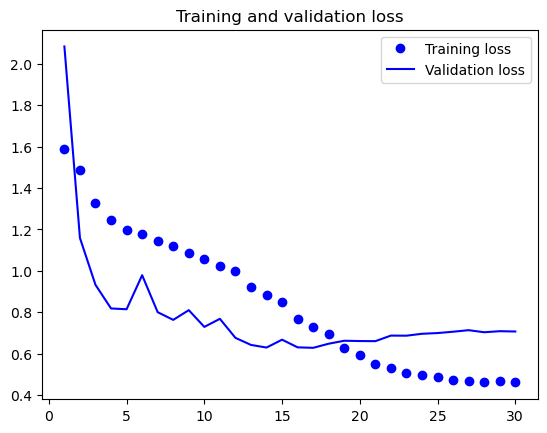

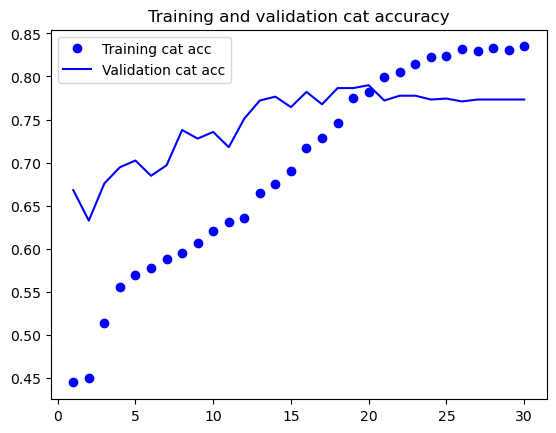

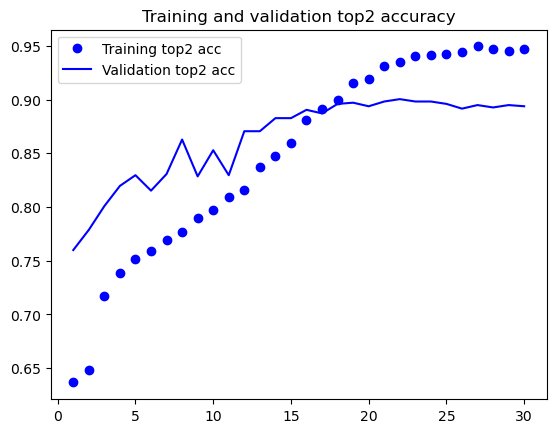

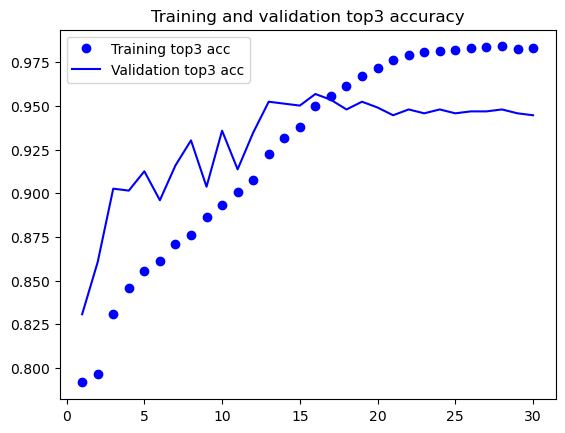

In [82]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()



plt.show()

In [83]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [84]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [85]:
# Print the label associated with each class
test_batches.class_indices

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'MEL': 4,
 'NV': 5,
 'SCC': 6,
 'UNK': 7,
 'VASC': 8}

In [87]:
# make a prediction
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

911/911 [==============================] - 10s 11ms/step


In [88]:
predictions.shape

(911, 9)

In [89]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [90]:
test_labels.shape

(911,)

In [96]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
print(cm)

[[  7   4   2   0   0   0   1   0]
 [  3  43   3   0   3   7   0   1]
 [  5  17  54   0   3  26   1   1]
 [  0   2   0   2   0   3   0   0]
 [  0   1  27   0  17  28   0   1]
 [  1  13  12   0  14 582   0   1]
 [  0   8   3   0   1   5   1   0]
 [  0   0   0   0   0   2   0   6]]


In [92]:
test_batches.class_indices

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'MEL': 4,
 'NV': 5,
 'SCC': 6,
 'UNK': 7,
 'VASC': 8}

Confusion matrix, without normalization
[[  7   4   2   0   0   0   1   0]
 [  3  43   3   0   3   7   0   1]
 [  5  17  54   0   3  26   1   1]
 [  0   2   0   2   0   3   0   0]
 [  0   1  27   0  17  28   0   1]
 [  1  13  12   0  14 582   0   1]
 [  0   8   3   0   1   5   1   0]
 [  0   0   0   0   0   2   0   6]]


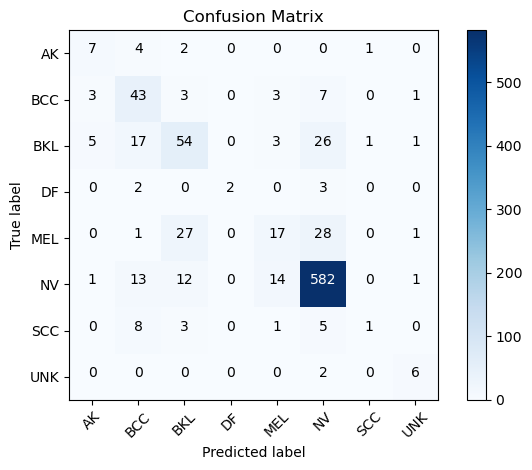

In [97]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [98]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [99]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

          AK       0.44      0.50      0.47        14
         BCC       0.49      0.72      0.58        60
         BKL       0.53      0.50      0.52       107
          DF       1.00      0.29      0.44         7
         MEL       0.45      0.23      0.30        74
          NV       0.89      0.93      0.91       623
         SCC       0.33      0.06      0.10        18
         UNK       0.60      0.75      0.67         8

    accuracy                           0.78       911
   macro avg       0.59      0.50      0.50       911
weighted avg       0.77      0.78      0.77       911

